# Eigenfaces

### import packages

In [339]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import notebook

from rputil import *

%matplotlib inline

### load data

In [340]:
n_images = 1000

data = np.empty((187500, n_images)) # images are 250x250

for i,filename in enumerate(glob.iglob('lfw/**/*.jpg', recursive = True)):
    if i >= n_images:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im).flatten() # only using red channel for now
    im.close()

In [341]:
data /= 255

In [342]:
specific_image = np.copy(data[:,0])

In [343]:
specific_image

array([0.        , 0.        , 0.        , ..., 0.59215686, 0.63529412,
       0.71372549])

#### column-center the data

In [344]:
data_mean = np.expand_dims(np.mean(data, axis=1),1)
data -= data_mean

### define factorization functions

In [345]:
def svd_rank_k(A, k):
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    
    return U[:,:k], sigma[:k], Vh[:k]

In [346]:
# based on algorithms 4.1 (page 22) and 5.1 (page 29) of halko
# note that we are assuming Q has real entries in this implementation
def rsvd_rank_k(A, k, proj_dim=0.25):
    m, n = A.shape
    l = int(n * proj_dim)
    
    # Stage A
    omega = random.randn(n, l) # n x l
    Y = A @ omega # m x l
    Q, R = np.linalg.qr(Y) # m x l, l x l
    
    # Stage B
    B = Q.T @ A # l x n
    U_tilde, sigma, Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde # m x r

    return U[:,:k], sigma[:k], Vh[:k]

### calculate eigenfaces

In [347]:
k = 500

In [348]:
det_basis,_,_ = svd_rank_k(data, k)

In [349]:
rand_basis,_,_ = rsvd_rank_k(data, k)

In [350]:
def normalize_basis(basis):
    return (basis - np.min(basis))/(np.max(basis)-np.min(basis))

In [351]:
normalized_det_basis = normalize_basis(det_basis)

In [352]:
normalized_rand_basis = normalize_basis(rand_basis)

In [353]:
def plot_eigenfaces(basis, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250,3))

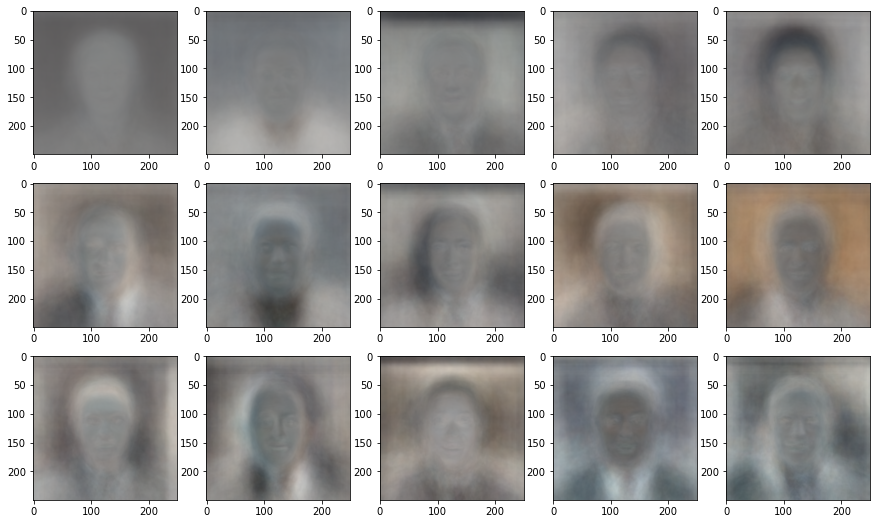

In [354]:
plot_eigenfaces(normalized_det_basis, 3, 5)

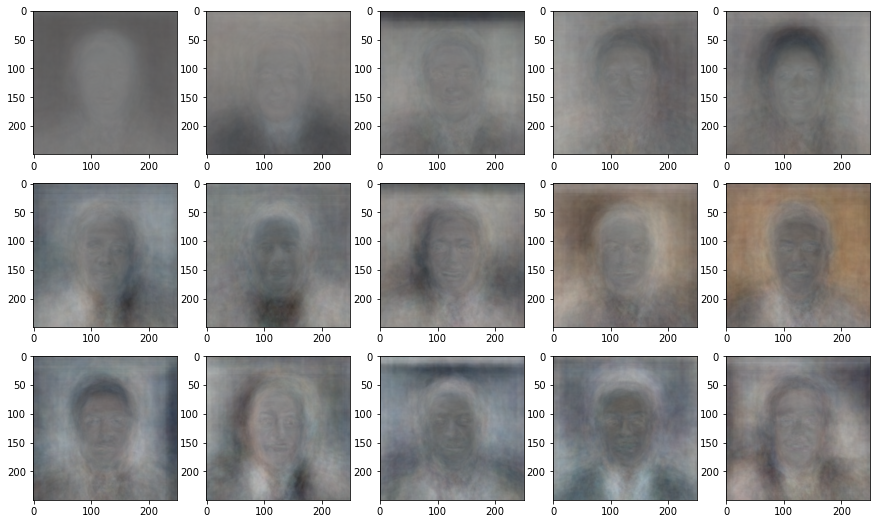

In [355]:
plot_eigenfaces(normalized_rand_basis, 3, 5)

In [356]:
coefficients = (specific_image - np.squeeze(data_mean)) @ det_basis

In [357]:
reconstructed_image = np.squeeze(data_mean) + (det_basis @ coefficients)

In [368]:
reconstructed_image

array([-0.08761127, -0.05782752, -0.00375193, ...,  0.51122994,
        0.57858803,  0.61144661])

In [358]:
# d = 5
# reconstructed_image = np.squeeze(data_mean) + (det_basis[:,:d] @ coefficients[:d])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


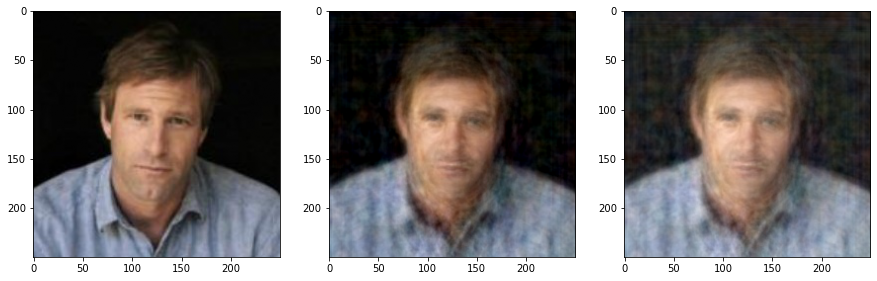

In [372]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(specific_image.reshape(250,250,3))
ax[1].imshow(reconstructed_image.reshape(250,250,3))
ax[2].imshow(normalize_basis(reconstructed_image).reshape(250,250,3))

### evaluate performance

In [367]:
proj_dim_range = np.arange(0.1, 0.9, 0.1)

start = perf_counter()
det_basis,_,_ = svd_rank_k(data, k)
end = perf_counter()
det_time = end - start

m, n = det_basis.shape


errors = []
rand_times = []

for d in proj_dim_range:
    print(f'Computing RSVD with subspace dimension {int(n * d)}...')
    
    start = perf_counter()
    rand_basis,_,_ = rsvd_rank_k(data, k, proj_dim=d)
    end = perf_counter()
    rand_time = end - start
    rand_times.append(rand_time)
    
    # possible sketchy fix for weird negative basis vectors
    for i in range(det_basis.shape[1]):
        if np.dot(det_basis[:,i], rand_basis[:,i]) < 0:
            rand_basis[:,i] *= -1
    
#     print(f'numer: {np.linalg.norm(rand_basis - det_basis)}, denom: {np.linalg.norm(det_basis)}')
    error = np.linalg.norm(rand_basis - det_basis) / np.linalg.norm(det_basis)
    errors.append(error)

Computing RSVD with subspace dimension 50...


IndexError: index 100 is out of bounds for axis 1 with size 100

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel('subspace dimension')

ax.plot(proj_dim_range, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(proj_dim_range, rand_times, c='g', label='Time')
ax2.set_ylabel('time elapsed (seconds)')

fig.legend(loc='upper right')

In [ ]:
errors